<a target="_blank" href="https://colab.research.google.com/github/michalis0/Business-Intelligence-and-Analytics/blob/master/labs/09%20-%20Regression%202/Exercises/Solutions/exercise_sol.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Multivariate Linear Regression, Overfitting and Crossvalidation

This exercise is an application of what you learned in the walkthrough and it will help you answer the quiz questions. The following cell gathers the different modules you need for this exercise (take a look at the sklearn library).

Some exercises consist of filling a part of the code without writing the whole code. Replace the `"YOUR CODE HERE"` by your own code.

In [1]:
# Useful starting lines
# %matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")

# Sklearn import
from sklearn.preprocessing import MinMaxScaler # Normalization
from sklearn.linear_model import LinearRegression # Regression linear model
from sklearn.model_selection import train_test_split # Splitting the data set
from sklearn.preprocessing import LabelEncoder #1-hot encoding
from sklearn.preprocessing import OneHotEncoder # Label encoding
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # Metrics for errors
from sklearn.model_selection import KFold # Cross validation
from sklearn.preprocessing import PolynomialFeatures
import statistics

## 1. Loading the dataset
This week, we are going to use the `audi` dataset. Our task is to figure out how the different features have an influence the price of a car.
Load the pandas dataset from the given URL. Then display the first 5 rows. How many observations and columns do we have?

In [2]:
url = 'https://media.githubusercontent.com/media/michalis0/Business-Intelligence-and-Analytics/master/data/audi.csv'
# Load the data
audi = pd.read_csv(url)
display(audi.head())

# Observations and columns (dimensions)
print("Number of observations", audi.shape[0])
print("Number of columns", audi.shape[1])

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0


Number of observations 10668
Number of columns 9


An overview of the columns:
 * `price`: price in £
 * `model` : audi model
 * `year`: registration year
 * `transmission`: type of gearbox
 * `mileage`: distance used
 * `fuelType`: engine fuel
 * `tax` : road tax
 * `mpg`: miles per gallon
 * `engineSize`: size in litres

 We will try to predict the price using some of the other variables.

## 2. Dealing with categorical variables
First we have to deal with our categorical variables. Since it's not possible to regress anything on them, we must transform them using techniques such as label encoding or 1-hot encoding. In this part, our goal is to obtain a final dataset :`AUDI` where there is no categorical variable.

Using the label encoding approach, convert the `fuelType` and `model` columns to numerical columns.

Hint: Use the `LabelEncoder` from sklearn. Note that you have to remove the original categorical column and replace it with the label encoded column.



In [3]:
audi.dtypes

model            object
year              int64
price             int64
transmission     object
mileage           int64
fuelType         object
tax               int64
mpg             float64
engineSize      float64
dtype: object

In [4]:
le = LabelEncoder()
audi['fuelType'] = le.fit_transform(audi['fuelType'])
le = LabelEncoder()
audi['model'] = le.fit_transform(audi['model'])
display(audi.head())
display(audi.dtypes)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,0,2017,12500,Manual,15735,2,150,55.4,1.4
1,5,2016,16500,Automatic,36203,0,20,64.2,2.0
2,0,2016,11000,Manual,29946,2,30,55.4,1.4
3,3,2017,16800,Automatic,25952,0,145,67.3,2.0
4,2,2019,17300,Manual,1998,2,145,49.6,1.0


model             int64
year              int64
price             int64
transmission     object
mileage           int64
fuelType          int64
tax               int64
mpg             float64
engineSize      float64
dtype: object

Next, transform the `transmission` column using the one-hot encoding approach.

**hint :** Use the `get_dummies` from pandas. Remember to set `dtype=int` for the `get_dummies` method. After concatenating the new dataframe with the one hot encoded values to the `audi` dataframe, remember to drop the original categorical column (`transmission`) from the dataframe.




In [5]:
tr_dummies = pd.get_dummies(audi["transmission"], dtype=int)
audi = pd.concat([audi, tr_dummies], axis=1)
audi.drop("transmission", axis=1, inplace=True)

audi.head()

,model,year,price,mileage,fuelType,tax,mpg,engineSize,Automatic,Manual,Semi-Auto
0,0,2017,12500,15735,2,150,55.4,1.4,0,1,0
1,5,2016,16500,36203,0,20,64.2,2.0,1,0,0
2,0,2016,11000,29946,2,30,55.4,1.4,0,1,0
3,3,2017,16800,25952,0,145,67.3,2.0,1,0,0
4,2,2019,17300,1998,2,145,49.6,1.0,0,1,0


Let's get an overview of our transformed dataset without categorical variables.

In [6]:
# Display the types of the columns
display(audi.dtypes)

# Display the 5 first lines of the dataset
display(audi.head())


model           int64
year            int64
price           int64
mileage         int64
fuelType        int64
tax             int64
mpg           float64
engineSize    float64
Automatic       int64
Manual          int64
Semi-Auto       int64
dtype: object

,model,year,price,mileage,fuelType,tax,mpg,engineSize,Automatic,Manual,Semi-Auto
0,0,2017,12500,15735,2,150,55.4,1.4,0,1,0
1,5,2016,16500,36203,0,20,64.2,2.0,1,0,0
2,0,2016,11000,29946,2,30,55.4,1.4,0,1,0
3,3,2017,16800,25952,0,145,67.3,2.0,1,0,0
4,2,2019,17300,1998,2,145,49.6,1.0,0,1,0


## 3. Multivariate Regression
Now that we have transformed the categorical variables, let's get to regression. Using the steps we covered last week, try to predict the `price` using all of our variables.

- Split the data to training and test using the sklearn `train_test_split` method. Use theses parameters for the method : `test_size=0.2, random_state=10, shuffle=True`

- Use the model `LinearRegression()`

- compute the MAE, MSE and R^2 on the testing set.

<h2> Important: This part answers the Moodle quiz question 1. <h2>

In [7]:
# We want to predict the price using all the other columns
y = audi["price"]
X = audi.drop("price", axis = 1)

In [8]:
# Split the data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, shuffle=True)

# Create the model
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Performance metrics
print("Test scores: ")
print("MAE %.4f" % mean_absolute_error(y_test, predictions))
print("MSE %.4f" % mean_squared_error(y_test, predictions))
print("R^2 %.4f" % r2_score(y_test, predictions))


Test scores: 
MAE 3293.2431
MSE 25976640.2029
R^2 0.7987


## 4.Polynomial Linear Regression

Generate a new feature matrix named `X_poly` consisting of all polynomial combinations of all the features available with degree less than or equal to a degree of **2**.

Use all the independant variables at your disposition (Use the encoded variables to perform this regression).

Use the function `PolynomialFeatures()`.

What is the lenght of this new feature Matrix?

In [9]:
# Polynomial regression
poly = PolynomialFeatures(2) # We want degree-2 polynomial features
X_poly = poly.fit_transform(X) #Normalizing

# find the length of this feature matrix
print(f'The lenght of the new feature Matrix is : {len(X_poly[0])} ')

The lenght of the new feature Matrix is : 66 


Do a linear regression using the feature Matrix you just created.

Use the function `LinearRegression()`

What is the R^2 of the regression you performed?

In [10]:
# Linear Regression
LR = LinearRegression(fit_intercept=False) # we don't need fit intercept sice polynomial features function add a column of ones to the data
LR.fit(X_poly, y)

# What is the R^2?
print("R^2 score: ", LR.score(X_poly, y))

R^2 score:  0.9204946327006828


We want to find what is the **best polynomial degree** for our regression.

- We will compute the **MSE** for the training and the testing data of the polynomial degrees from 1 to 5 (included)

- For splitting the data to training and test, use these parameters: `test_size=0.2, random_state=10, shuffle=True`

- Represent your results in a graph.

What is the best choice of the polynomial degree based on the MSE values on the test data?

<h2> Important: This part answers the moodle quiz question 2. <h2>

Text(0, 0.5, 'error')

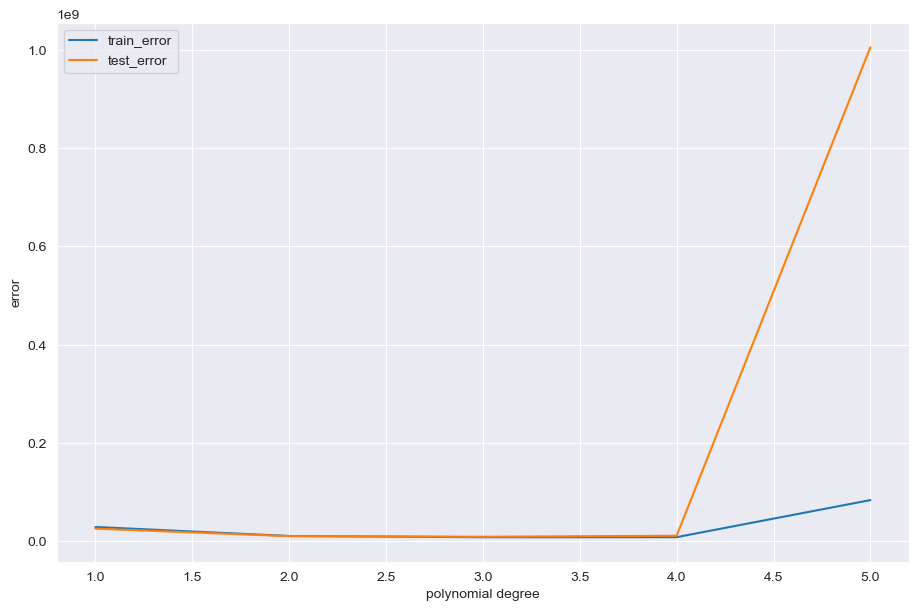

In [11]:
# Create the lists to store our results
train_err = []
test_err = []

# Make the loop for degree 1 to 5 (included) and store the regression results in the appropriate list
for f in range(1,6):
    poly = PolynomialFeatures(f)
    X_poly = poly.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=10, shuffle=True)
    LR = LinearRegression(fit_intercept=False)
    LR.fit(X_train, y_train)
    train_err.append(mean_squared_error(y_train, LR.predict(X_train)))
    test_err.append(mean_squared_error(y_test, LR.predict(X_test)))

# Represent your the MSE in a graph
fig=plt.figure(figsize=(11,7))
plt.plot(range(1,6), train_err, label="train_error")
plt.plot(range(1,6), test_err, label="test_error")
plt.legend(fontsize=10)
plt.xlabel("polynomial degree")
plt.ylabel("error")

In [12]:
test_err

[25976640.202931777,
 10700384.113076435,
 9491250.768280094,
 11586622.84829022,
 1005012283.400704]

In [13]:
# Find the best polynomial degree
best_degree = test_err.index(min(test_err)) + 1
print(f"The best polynomial degree is {best_degree} with a MSE of {min(test_err)}")

The best polynomial degree is 3 with a MSE of 9491250.768280094
